In [1]:
import os
import json
import logging
from pathlib import Path
from PyPDF2 import PdfReader
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.output_parsers import BooleanOutputParser
from typing import Any, Dict, List, Optional, Tuple, Union
import pandas as pd
from types import SimpleNamespace

In [2]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler('patent_analysis.log'), logging.StreamHandler()]
)
logger = logging.getLogger(__name__)


In [3]:
from openai import OpenAI
from math import exp
import numpy as np
from IPython.display import display, HTML
import os

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [4]:
def get_completion(
    messages: list[dict[str, str]],
    model: str = "gpt-4o-mini",
    max_tokens=500,
    temperature=0,
    stop=None,
    seed=None,
    tools=None,
    logprobs=None,  # whether to return log probabilities of the output tokens or not. If true, returns the log probabilities of each output token returned in the content of message..
    top_logprobs=None,
) -> str:
    
    system_message = {
        "role": "system",
        "content": """You are a highly experienced research chemist with a PhD and 20+ years of experience in chemistry and patent analysis. 
Your expertise includes:
- Publishing numerous research papers
- Reading thousands of chemical patents
- Leading laboratory research teams
- Writing detailed experimental procedures
- Analyzing chemical documentation

You are specifically trained to identify experimental data in chemical patents with extremely high accuracy."""
    }
    
    # Insert system message at the beginning of messages list
    messages.insert(0, system_message)

    params = {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "stop": stop,
        "seed": seed,
        "logprobs": logprobs,
        "top_logprobs": top_logprobs,
    }
    if tools:
        params["tools"] = tools

    completion = client.chat.completions.create(**params)
    return completion

In [5]:
def analyze_file(file_path: str) -> Tuple[str, str]:

    results=[]
    file_name = os.path.basename(file_path)
    absolute_path = os.path.abspath(file_path)
    CLASSIFICATION_PROMPT = """
You are analyzing a chemical patent about olefin polymerization catalysts. Check if this page contains EXPERIMENTAL DATA.

PATENT SECTIONS:
1. EXPERIMENTAL Sections (answer YES):
   - "EXAMPLES"
   - "COMPARATIVE EXAMPLES" 
   - "WORKING EXAMPLES"
   - "PREPARATION EXAMPLES"
   - "POLYMERIZATION EXAMPLES"
   - "TABLES"

2. NON-EXPERIMENTAL Sections (answer NO):
   - "TECHNICAL FIELD"
   - "BACKGROUND ART"
   - "CLAIMS"
   - "ABSTRACT"

ANSWER YES IF YOU SEE:
1. ANY part of experimental procedures (including continued from previous page):
   - Beginning: "The catalyst was prepared by mixing..."
   - Middle: "...was stirred for 2h at 80°C..."
   - End: "...yielding 5.2g of product"
   - Table parts (even incomplete)
   - Continued analytical data

2. Detailed procedures, like:
   "The catalyst was prepared by mixing..."
   "Polymerization was carried out..."
   "To a flask was added..."
   "The mixture was stirred at..."
   "Table №1"

3. ANY measurements:
   Masses: "5.2 g", "10 mg", "2.5 wt%"
   Volumes: "100 ml", "50 μL"
   Temperatures: "25°C", "80 °C"
   Times: "2 h", "30 min"
   Pressures: "5 bar", "0.5 MPa"

4. Results tables with ANY numbers

ANSWER NO IF PAGE ONLY HAS:
- General descriptions without procedures
- Lists of compounds without quantities
- Patent claims
- Theoretical explanations

CRITICAL RULES:
1. Even PARTIAL experimental data makes the page experimental (YES)
2. Beginning, middle, or end of procedures count as experimental
3. Continued tables from previous pages count as experimental
4. Look for procedure descriptions with measurements first!

Answer ONLY "YES" or "NO"

Analyze this text: {text}"""

    with open(file_path, "rb") as f:
        reader = PdfReader(f).pages
        text = []
        for page in reader:
            text.append(page.extract_text())
    
    for i, page in enumerate(text):
        print(f"\nHeadline: {page[:200]}")
        
        # Check if page is empty or contains only whitespace
        if not page.strip():
            # Create mock response for empty pages
            top_two_logprobs = [
                SimpleNamespace(token="NO", logprob=0.0),  # log(1.0) = 0.0 for 100% probability
                SimpleNamespace(token="YES", logprob=float('-inf'))  # -inf for 0% probability
            ]
        else:
            API_RESPONSE = get_completion(
                [{"role": "user", "content": CLASSIFICATION_PROMPT.format(text=page)}],
                model="gpt-4o-mini",
                logprobs=True,
                top_logprobs=2,
                max_tokens=1,
                temperature=0,
            )
            top_two_logprobs = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs

        html_content = ""
        for j, logprob in enumerate(top_two_logprobs, start=1):
            html_content += (
                f"<span style='color: cyan'>Output token {j}:</span> {logprob.token}, "
                f"<span style='color: darkorange'>logprobs:</span> {logprob.logprob}, "
                f"<span style='color: magenta'>linear probability:</span> {np.round(np.exp(logprob.logprob)*100,2)}%<br>"
            )
        display(HTML(html_content))
        print("\n")

        results.append({
                        'file_name': file_name,
                        'file_path': absolute_path,
                        'page_number': i+1,
                        '1st_token': top_two_logprobs[0].token,
                        '1st_logprob': np.round(np.exp(top_two_logprobs[0].logprob)*100,2),
                        '2nd_token': top_two_logprobs[1].token,
                        '2nd_logprob': np.round(np.exp(top_two_logprobs[1].logprob)*100,2),
                        'text': page
                    })

    df = pd.DataFrame(results)
    df.to_csv(f"/home/anatoly_kayda/Desktop/mipt/kayda_thesis/output_ chunk_is_page/{file_name}_parsed.csv")
    return df

# Анализ данных

In [6]:
patent_data = '/home/anatoly_kayda/Desktop/mipt/data'
patent_list = '/home/anatoly_kayda/Desktop/mipt/kayda_thesis/best_10_patents.txt'
best_10_patents = []
with open(patent_list) as f:
    for patent in f.read().splitlines() :
        best_10_patents.append(patent+'.pdf')

best_10_patents_paths = []
for dirpaths, dirnames, filenames in os.walk(patent_data):
    for filename in filenames:
        if filename in best_10_patents:
            best_10_patents_paths.append(dirpaths+"/"+filename)
best_10_patents_paths = {os.path.splitext(os.path.basename(path))[0]: path for path in best_10_patents_paths}
best_10_patents_paths

{'US6617405': '/home/anatoly_kayda/Desktop/mipt/data/unioncarbide/US/US6617405.pdf',
 'US6248831': '/home/anatoly_kayda/Desktop/mipt/data/unioncarbide/US/US6248831.pdf',
 'US20060046928': '/home/anatoly_kayda/Desktop/mipt/data/novolen/US/US20060046928.pdf',
 'US4843132': '/home/anatoly_kayda/Desktop/mipt/data/novolen/US/US4843132.pdf',
 'US4148754': '/home/anatoly_kayda/Desktop/mipt/data/hoehst/US/US4148754.pdf',
 'US4481301': '/home/anatoly_kayda/Desktop/mipt/data/mobiloil/US/US4481301.pdf',
 'US4849389': '/home/anatoly_kayda/Desktop/mipt/data/mobiloil/US/US4849389.pdf',
 'US4374753': '/home/anatoly_kayda/Desktop/mipt/data/chemplex/US/US4374753.pdf',
 'US9352308': '/home/anatoly_kayda/Desktop/mipt/data/braskem/US/US9352308.pdf',
 'US20060166812': '/home/anatoly_kayda/Desktop/mipt/data/braskem/US/US20060166812.pdf'}

In [7]:
for patent_name, patent_path in best_10_patents_paths.items():
    analyze_file(patent_path)


Headline: USOO6617405B1 
 (12) United States Patent (10) Patent No.: US 6,617,405 B1 
 Jorgensen (45) Date of Patent: Sep. 9, 2003 
 (54) PROCESS FOR THE PREPARATION OF 5,601,472 A 2/1997 Parker ...............


2025-03-17 20:43:53,611 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,617.405 B1 
 1 
 PROCESS FOR THE PREPARATION OF 
 POLYETHYLENE 
 TECHNICAL FIELD 
 This invention relates to a proceSS for the preparation of 
 polyethylene with a focus on catalyst activation. 



2025-03-17 20:43:54,554 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,617.405 B1 
 3 
 DISCLOSURE OF THE INVENTION 
 An object of this invention, therefore, is to provide a proceSS for preparing polyethylene, which overcomes the 
 deficiencies associated with Separ


2025-03-17 20:43:55,186 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,617.405 B1 
 S 
 aluminum, tri-n-hexyl aluminum, dimethyl aluminum chloride, and tri-n-octyl aluminum. Particularly preferred 
 activators are: a Sequential mixture of tri-n-hexylaluminum 
 and d


2025-03-17 20:43:55,887 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,617.405 B1 
 7 
 bottom of the residence time pot. The impeller promotes Some radial mixing, but mainly assures that the bottom Section of the residence time pot does not experience SuS pended so


2025-03-17 20:43:56,780 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,617.405 B1 
 9 
 in the range of about 10 to about 150 psig, and is preferably 
 in the range of about >20 to about 120 psig. The balance of the total pressure is provided by alpha-olefin (if use


2025-03-17 20:43:57,470 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,617.405 B1 
 11 
 fashion over a larger range of polymer MFR (melt flow ratio), hexane extractables, and polymer bulk density. The Smaller reaction System is used illustratively to avoid experi 



2025-03-17 20:43:58,114 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,617.405 B1 
 13 
 TABLE II 
 RESIN PROPERTIES 1. 2 3 4 
 Melt Index, I2 (dg/min) 1.12 1.07 O.90 1.08 
 Density (g/cm3) 91.95 91.82 91.85 91.90 
 MFR 26.2 26.O 26.O 24.9 
 Residual Al (ppm) 32 41 


2025-03-17 20:43:58,625 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,617.405 B1 
 TABLE IV-continued TABLE VI(B)-continued 
 Examples Comparative Examples 
 RESIN PROPERTIES 5 6 7 8 9 S RESIN PROPERTIES 5 6 7 8 
 APS (inches) O17 O18 O17 O18 O18 Added Activator/ED


2025-03-17 20:43:59,247 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,617.405 B1 
 17 
 aliphatic hydrocarbon radical having 1 to 14 carbon 
 atoms, each X is independently chlorine, bromine, or 
 iodine, and n is 1 to 3; and 
 (iv) no additional activator is intro


2025-03-17 20:43:59,832 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: USOO6248831B1 
 (12) United States Patent (10) Patent No.: US 6,248,831 B1 
 Maheshwari et al. (45) Date of Patent: Jun. 19, 2001 
 (54) HIGH STRENGTH POLYETHYLENE FILM (56) References Cited 
 (75) In


2025-03-17 20:44:01,028 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,248,831 B1 
 1 
 HIGH STRENGTH POLYETHYLENE FILM 
 TECHNICAL FIELD 
 This invention relates to a process for preparing an in Situ polyethylene blend, which can be converted into film having an im


2025-03-17 20:44:01,991 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,248,831 B1 
 3 
 Strength, particularly in terms of dart drop. Other objects and 
 advantages will become apparent hereinafter. 
 According to the present invention Such a proceSS for the 
 produ


2025-03-17 20:44:02,515 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,248,831 B1 
 S 
 Sometimes, e.g., with high density polyethylene, the bubble 
 looks like a cylindrical Semi-molten tube with a diameter approximately equal to the ring diameter before being blow


2025-03-17 20:44:03,098 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,248,831 B1 
 7 
 interconnecting device using nitrogen or Second reactor recycle gas as a transfer medium. 
 In the high molecular weight (HMW) reactor: 
 Because of the low values, instead of me


2025-03-17 20:44:03,746 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,248,831 B1 
 the cocatalyst Solution. Optionally, the liquid cocatalyst can be fed directly to the fluidized bed. The partially activated catalyst precursor is preferably injected into the fluidi


2025-03-17 20:44:05,177 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,248,831 B1 
 11 
 To a 10 gallon Stainless Steel reaction/filter vessel are charged 1,892 grams of magnesium/titanium alkoxide pre 
 cursor powder together with 3.5 kilograms of hexane. Then, a s


2025-03-17 20:44:05,950 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: reaction 
 conditions 
 temperature(C.) pressure (psia) 
 COOOle 
 C2 partial pressure(psia) 
 H2/C2 molar 
 ratio 
 C6/C2 
 molar ratio 
 recycle isopentane 
 (mol%) C2 feed (Ibs/hr) catalyst feed 
 


2025-03-17 20:44:06,632 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,248,831 B1 
 15 
 The SECs reveal that the examples 2 and 3 products have 
 a broader molecular weight distribution than the example 1 
 product. It is noted that the broadening occurs in the hig


2025-03-17 20:44:08,635 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 17 
 TABLE X-continued 
 reaction 
 conditions 
 production rate 
 for each reactor 
 (Ibs/hr) bed weight (Ibs) 
 fluidized bulk 
 density 
 (Ibs/cu ft) 
 bed volume 
 (cu ft) 
 residence time 
 (hrs)


2025-03-17 20:44:09,297 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,248,831 B1 
 TABLE XII-continued 
 reaction first second 
 conditions reactor reactor 
 (wt %) 
 fines less than O.21 O.53 
 120 mesh (wt %) 
 Notes to above Tables: 
 1. Resin properties for Sec


2025-03-17 20:44:10,177 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 6,248,831 B1 
 21 
 8. The process defined in claim 7 wherein the blend has a melt index (I5) in the range of about 0.1 to about 0.6 grams per 10 minutes; a melt flow ratio (I 21.6/I 5) in the rang


2025-03-17 20:44:11,125 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: (19) United States US 20060046928A1 
 (12) Patent Application Publication (10) Pub. No.: US 2006/0046928A1 
 Klendworth et al. (43) Pub. Date: Mar. 2, 2006 
 (54) ZIEGLER-NATTA CATALYST AND METHOD (52


2025-03-17 20:44:12,141 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: Patent Application Publication Mar. 2, 2006 Sheet 1 of 3 US 2006/0046928A1 
 G.   


2025-03-17 20:44:12,654 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: Patent Application Publication Mar. 2, 2006 Sheet 2 of 3 US 2006/0046928A1 
 O. 2   


2025-03-17 20:44:13,476 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0046928A1 Mar. 2, 2006 Sheet 3 of 3 Patent Application Publication 
 3 O.   


2025-03-17 20:44:14,131 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0046928A1 
 ZEGLER-NATTA CATALYST AND METHOD FOR 
 MAKING AND USING SAME 
 FIELD OF THE INVENTION 
 0001. The present invention relates to catalysts, and par ticularly to Ziegler-Natta catalys


2025-03-17 20:44:14,784 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0046928A1 
 from about 0.5 wt % to about 3.0 wt % of the silica seeding agent is used relative to the magnesium-halide compound. 
 Generally, a higher ratio of magnesium-halide to Silica 
 See


2025-03-17 20:44:15,831 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0046928A1 
 include mono- and polyfunctional carboxylic acids, car boxylic anhydrides and carboxylic esters, and ketones, 
 ethers, alcohols, lactones as well as organic phosphorus and 
 Silic


2025-03-17 20:44:16,649 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0046928A1 
 sium hydroxide and iodomagnesium hydroxide. Among 
 these compounds the magnesium dihalides corresponding to 
 the formula MgX are preferred wherein X is a halogen. Especially pref


2025-03-17 20:44:17,531 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0046928A1 
 due to the difficulty in finding Such a Single Substance, most polypropylene catalysts employ two separate Substances for 
 their internal and external electron donors. 
 0044 Pref


2025-03-17 20:44:18,241 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0046928A1 
 0056 Next, the solid catalyst Support particles were 
 added slowly to a third flask containing 200 ml of neat TiCl, 
 which had been pre-cooled to about 0° C. After the tem peratu


2025-03-17 20:44:19,103 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0046928A1 
 1133 at a temperature of 230 C. and under a load of 2.06 kg. Certain applications might require different molecular 
 weights than those mentioned above and are contemplated to be 


2025-03-17 20:44:19,924 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0046928A1 
 17. The method of making a magnesium-halide Support 
 according to claim 14, wherein the alkanol is Selected from the group consisting of ethanol, methanol and 2-ethyl-1- 
 hexanol


2025-03-17 20:44:20,536 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: United States Patent (19) 
 Werner et al. 
 54 PREPARATION OF HOMO- AND COPOLYMERS OF PROPENE USINGA 
 ZEGLER-NATTA CATALYST SYSTEM 
 Rainer A. Werner, Bad Durkheim; Ralf Zolk, Hessheim, both of Fed. 


2025-03-17 20:44:23,802 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,843,132 1. 
 PREPARATION OF HOMO- AND COPOLYMERS 
 OF PROPENE USINGAZEGLER-NATA 
 CATALYST SYSTEM 
 The present invention relates to a process for the preparation of homopolymers of propene and copo


2025-03-17 20:44:24,692 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,843,132 3 
 where R is an aryl, alkylaryl or alkyl radical of not more than 16, preferably not more than 10, carbon atoms, in particular phenyl, tolyl or ethylphenyl, R2 is 
 alkyl of not more than 


2025-03-17 20:44:25,348 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,843,132 5 
 weight of the titanium tetrachloride being used per 10 parts by weight of the solid-phase intermediate obtained from the first stage, and finally (1.3) in a third stage, the solid-phase 


2025-03-17 20:44:26,064 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,843,132 7 
 resulting solid is then isolated by filtration and washed with n-heptane to give the carrier (III), 
 (IV) titanium tetrachloride and (V) phthaloyl dichloride, in such a way that first (


2025-03-17 20:44:26,809 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,843,132 
 resulting solid-phase intermediate is isolated by filtra tion, and finally (1.3) in a third stage, the solid-phase intermediate obtained in the second stage is extracted with n-heptane 10 


2025-03-17 20:44:27,500 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,843,132 11 
 where X and Y together form oxygen or X and Y are each chlorine or C1-C10-alkoxy, in such a way 
 that first 
 either (a) (1.1.1.a) in a first substage, the magnesium chloride (I) 
 and


2025-03-17 20:44:28,116 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: United States Patent (19) 
 Strobel et al. 
 (54) PROCESS FOR THE PREPARATION OFA CATALYST AND CATALYST USED IN OLEFN POLYMERZATION 
 75) Inventors: Wolfgang Strobel, Hofheim; Rainer Franke, Frankfurt


2025-03-17 20:44:29,417 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,148,754 1. 
 PROCESS FOR THE PREPARATION OFA 
 CATALYST AND CATALYST USED IN OLEFN 
 POLYMERZATION 
 The present invention relates to the preparation of a catalyst for the polymerization of ethylene


2025-03-17 20:44:31,982 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,148,754 3 Suitable halogen-containing magnesium-organic compounds are compounds of the formula RMgX, in which R is a hydrocarbon radical having from 1 to 20, preferably from 2 to 10 carbon atoms and


2025-03-17 20:44:32,644 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,148,754 
 wherein R2 and R2 is hydrogen, an alkyl radical, an alkylene radical having a non-terminal double bond or a mononuclear aryl radical and a is 0 or 1, are used prefer ably. There may be men


2025-03-17 20:44:33,263 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,148,754 7 
 ous phase in a fluidized bed. The use of oxide carriers having a particle size of more than 30 Jum, which may be obtained for example by separating fine particles by sieving, prevents fi


2025-03-17 20:44:34,042 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,148,754 
 weight below 50 m. 125,000 g of polyethylene per gram of titanium and 5,809 g of polyethylene per gram of the catalyst component A are obtained. 
 COMPARATIVE EXAMPLE A 
 The example demon


2025-03-17 20:44:34,816 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,148,754 11 
 EXAMPLE 7 
 Into a 1 liter autoclave made from stainless steel there 
 are introduced 500 ml of Diesel oil, and the air is dis placed by evacuating and by introducing nitrogen 5 
 under


2025-03-17 20:44:35,760 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,148,754 3 polyethylene, per gram of the catalyst component A, 330 g. 
 EXAMPLE 11 
 Ethylene is polymerized under the conditions de scribed in Example 4 in the presence of 0.62 g of the catalyst com


2025-03-17 20:44:36,583 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,148,754 5 ity of the powder 0.077 cm3-sec/g. Pergram of titanium there are obtained 12,700 g, per gram of the component A, 467 g, of polyethylene. 
 EXAMPLE 19 
 A porous aluminum silicate (85.7% of


2025-03-17 20:44:37,481 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,148,754 17 
 14. A compound prepared according to the process as 
 defined in claim 13. 
 15. A process as defined in claim 1, wherein R* and R6 are alkyl of from 1 to 16 carbon atoms. 16. A compoun


2025-03-17 20:44:38,152 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: United States Patent (19) 
 Nowlin et al. 
 54 
 75 
 (73) 
 (21) 
 22 
 (63) 
 51 (52) 
 (58) 
 56) HIGHILY ACTIVE CATALYST 
 COMPOSITION FOR POLYMERIZNG 
 ALPHA-OLEFNS 
 Inventors: Thomas E. Nowlin,


2025-03-17 20:44:39,737 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: U.S. Patent Nov. 6, 1984 Sheet 1 of 5 4,481,301 
 GAS RECYCLE 
 INERT GAS 
 GAS FEED 
   


2025-03-17 20:44:40,365 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 





Headline: 4,481,301 Sheet 3 of 5 U.S. Patent Nov. 6, 1984 
 LSÅTVLVO Z'XE DE LSÅTVIVO y o Oi LV8 ZO/#70 SA Å LISNEC] 
 MSNBC OO/SWWS)   


2025-03-17 20:44:41,010 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: U.S. Patent Nov. 6, 1984 Sheet 4 of 5 4,481,301 
 ON 
 GN 
 O N s 9 a. s 
 V & al 3 s cos O g s 
 N L. Q s cos 2 v C) 
 C O) S 
 OO/SWWOALISN3O s   


2025-03-17 20:44:51,154 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 





Headline: 4,481,301 
 HGHLY ACTIVE CATALYST COMPOSITION 
 FOR POLYMERIZING ALEPHA-OLEFNS 
 CROSS REFERENCE TO RELATED 
 APPLICATION 
 This application is a continuation-in-part of U.S. ap 
 plication Ser. No. 3


2025-03-17 20:44:51,974 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 3 (i) contacting a solid, porous carrier having reactive OH groups with a liquid in the absence of ball milling, said liquid containing at least one organomagnesium composition having the em


2025-03-17 20:44:52,690 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 5 Chemically bound water, as represented by a pres ence of OH groups in the carrier, may be present when the carrier is contacted with water-reactive magnesium compounds in accordance with a


2025-03-17 20:44:53,513 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 
 C2H5 
 O 
 Although organomagnesium compounds of the for 
 mula RMgX tend to be insoluble in non-Lewis base solvents such as hexane, these organomagnesium com pounds may be completely solu


2025-03-17 20:44:54,153 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 
 may, optionally, be in the form of a complex with one or more electron donating agents (i.e. Lewis bases). More particularly, when ethylmagnesium chloride is precipi tated from a hexane/te


2025-03-17 20:44:54,913 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 11 
 alkoxide portion thereof is a C1-C6 alkoxide), or mix tures thereof. A preferred tetravalent titanium com pound is TiCl4. It may also be possible to replace some or all of the above-men


2025-03-17 20:44:55,622 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 13 
 certain aspects of the present invention is felt to be sufficient to produce a linear low density polyethylene polymer which is an ethylene/1-hexene copolymer, e.g., having a density of


2025-03-17 20:44:56,419 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 15 
 fluidized bed through distribution plate 20. The com pressor 25 can also be placed upstream of the heat ex changer 26. The distribution plate 20 plays an important role in the operation


2025-03-17 20:44:56,956 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 17 
 is then opened to deliver the product to an external recovery zone. Valve 38 is then closed to await the next product recovery operation. 
 Finally, the fluidized bed reactor is equippe


2025-03-17 20:44:57,618 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 19 
 substantially in accordance with this Karol et al patent are referred to herein as "comparative A' catalysts or simply as 'A' catalysts. The comparative A catalysts are felt to be subst


2025-03-17 20:44:58,253 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 21 I2 melt index level over a range of magnesium loadings into Davison 952 silica dried at 200 C. 
 If silica dried at 800 C, is used in place of silica dried at 200 C., the copolymerization


2025-03-17 20:44:59,136 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 23 The catalyst of Example 2 may generate about four times as much heat (per area of catalyst particle) as the Example 6 catalyst. This extra heat could result in se vere temperature gradien


2025-03-17 20:44:59,716 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 25 
 COMPARATIVE EXAMPLE B 
 The catalyst of this Comparative Example was pre pared in accordance with Example 7 of the Yamaguchi 
 et al U.S. Pat. No. 3,989,881. One will readily note the s


2025-03-17 20:45:00,294 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 27 28 
 TABLE IX-continued 
 COMPARISON OF EX.8 CATALYST WITH BAND C 
 Run Identification Polymerization Conditions" Product Obtained 
 Catayst Cat. Wt. H2 Total P TEAL Al/Ti Hexene Density 


2025-03-17 20:45:01,468 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,481,301 29 moles of said organomagnesium composition to the number of moles of OH groups on said silica being from about 1.1 to about 2.5, whereby said or ganomagnesium composition is reacted with s


2025-03-17 20:45:02,112 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: UNITED STATES PATENT AND TRADEMARK OFFICE 
 CERTIFICATE OF CORRECTION 
PATENT NO. : 4,481,301 Page 1 of 2 
 DATED : November 6, 1984 
INVENTOR(S) : T.E. NOWLIN, and K.P. WAGNER 
 It is Certified that 


2025-03-17 20:45:02,690 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: — 
 UNITED STATES PATENT AND TRADEMARK OFFICE 
 CERTIFICATE OF CORRECTION 
PATENT NO. 
DATED 
INVENTOR(S) : 
 It is Certified that error appears in the above-identified patent and that said Letters Pa


2025-03-17 20:45:03,191 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: United States Patent (19) 
 Nowlin et al. 
 54 
 75 
 73) 
 (21) 
 22) 
 51 (52) 
 (58) 
 56) CATALYST COMPOSITION FOR 
 POLYMERZNG ALPHA-OLEFIN 
 POLYMERS OF NARROW MOLECULAR 
 WEIGHT DISTRIBUTION 
 


2025-03-17 20:45:04,527 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: U.S. Patent Jul.18, 1989 Sheet 1 of 4 4,849,389 
 s N l 
 f i 
 s 
 (SONWSOHL) (OHILWO W9I SWW.9) 
 MINO?OOld   


2025-03-17 20:45:05,094 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: U.S. Patent Jul.18, 1989 Sheet 2 of 4 4,849,389 
 MFR vs -HEXENE CONTENT . 34 TEAL OR TMA AS COCATALYST - CATALYST OF EXAMPLE 
 30 u ul-F 28 u- - 
 2O 2 2.4 2.8 3.2 3.6 4.0 4.4 4.8 
 -HEXENE CONTENT I


2025-03-17 20:45:05,691 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: U.S. Patent Jul.18, 1989 Sheet 3 of 4 4,849,389 
 N 7 EFFECT OF DRYING TEMPERATURE 
 PRODUCTIVITY WITH TEAL OR TMA 
 2 TEAL 
 NTMA. 
 DRY 90'C U DRY 55 DRYING TEMPERATURE FIG. 
 CORRELATION BETWEEN MF


2025-03-17 20:45:06,180 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: U.S. Patent Jul.18, 1989 Sheet 4 of 4 4,849,389 
 CORRELATION BETWEEN MFR AND TMA CONCENTRATION 
 FOR A COMPARATIVE CATALYST (EXAMPLE 15B) AND THE INVENTIVE CATALYST (EXAMPLE: SMILAR TO 
 EXAMPLE I) 



2025-03-17 20:45:06,713 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,849,389 1. 
 CATALYST COMPOSITION FOR 
 POLYMERIZING ALPHAOLEFN POLYMERS 
 OF NARROW MOLECULAR WEIGHT 
 DISTRIBUTION 
 BACKGROUND OF THE INVENTION 
 1. Field of the Invention 
 The present invention


2025-03-17 20:45:07,742 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,849,389 3 
 as publication No. 0231102, disclose an alpha-olefin polymerization catalyst composition activated with trimethylaluminum which produces polymers having 
 relatively low values of MRF an


2025-03-17 20:45:08,460 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,849,389 5 
 into the solvent, preferably while stirring, and heating the mixture is about 25 to about 100 C., preferably about 40 to about 60° C. The slurry is then contacted with the aforementioned


2025-03-17 20:45:09,072 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,849,389 7 
 injection molding products which are resistant to warp ing or shrinking. 
 Suitable transition metal compounds used herein are compounds of metals of Groups IVA, VA, VIA or VIII of the P


2025-03-17 20:45:09,895 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,849,389 9 
 known to those skilled in the art, such MFR values are indicative of a relatively narrow molecular weight dis tribution of the polymer. As is also known to those skilled in the art, such


2025-03-17 20:45:10,721 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,849,389 11 
 heated to about 80° C. under purge of dry nitrogen, was filled with 400 mls of dry hexane, 200 mls of dry 1-hex ane and 3.0 mls of triethylaluminum (25 wt % in hex 
 ane). The reactor w


2025-03-17 20:45:11,277 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,849,389 13 catalyst precursor was injected with ethylene overpres 
 sure. The temperature was maintained at 80 C. and 150-200 grams of copolymer was produced in 50-60 
 minutes. The effect of increa


2025-03-17 20:45:12,075 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,849,389 15 
 The data indicate that the productivity of this catalyst precursor is particularly sensitive to the drying condi 
 tions. The precursor dried at 55 C. is about 25 percent more productiv


2025-03-17 20:45:12,689 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,849,389 17 
 (iii) contacting the slurry of step (ii) with at least one transition metal compound soluble in the non-polar 
 solvent; and (iv) combining the product of step (iii) with trimethyl 
 al


2025-03-17 20:45:13,219 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: United States Patent (19) 
 Pullukat et al. 
 (54) 
 (75) 
 73) 
 21) 
 22) 
 (51) (52) (58) 
 (56) POLYMERIZATION CATALYST AND 
 METHOD 
 Inventors: Thomas J. Pullukat, Hoffman Estates; Raymond E. Ho


2025-03-17 20:45:14,180 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: ; 4,374,753 1 
 POLYMERIZATION CATALYST AND METHOD 
 BACKGROUND OF THE INVENTION 
 In this invention, the polymerization catalysts useful in polymerizing and copolymerizing 1-olefins are pre 
 pared b


2025-03-17 20:45:14,808 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,374,753 3 rotational molding applications can be manufactured. The catalysts of this invention are stable, particulate, 
 and easy flowing. . . . . - 
 The alcohol modification allows the production


2025-03-17 20:45:15,384 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,374,753 
 RSixn 
 where m is 1, 2 or 3, n is 3, 2 or 1, respectively, and the total of m--n=4, X is a group chemically reactive with the hydroxyl groups of the silica or alumina such as chloride, am


2025-03-17 20:45:16,038 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,374,753 7 
 atmospheric to 10,000 psi gauge. It is carried out prefer ably under the technically interesting pressure in the 
 range of from 300-800 psi. The melt index of the polyethylene produced 


2025-03-17 20:45:16,584 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,374,753 9 
 -continued 
 Reactivity Melt 
 g/g cat/hr index 
 Catalyst 4190 . 1.4 
 EXAMPLE'S 
 A catalyst was made in the same manner as described in Example 1 except that a different magnesium com


2025-03-17 20:45:17,162 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,374,753 
stage, volatile materials were evaporated in a nitrogen 11 
stream by immersing the flaskin a bath at 100° C. Upon cooling, 15 ml hexane and 3.9 ml of dibutyl magnesium triethylaluminum com


2025-03-17 20:45:17,886 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: 4,374,753 13 
 3. The catalyst of claim 1 wherein said Group IIA compound or complex of (2) comprises an alkyl or aryl of magnesium or a magnesium complex. 
 4. The catalyst of claim 1 wherein said al


2025-03-17 20:45:18,462 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: (12) United States Patent 
 Braganca et al. US0093.52308B2 
 US 9,352,308 B2 
 May 31, 2016 (10) Patent No.: 
 (45) Date of Patent: 
 (54) SOLID CATALYST COMPONENT FOR 
 POLYMERIZATION AND 
 COPOLYMER


2025-03-17 20:45:19,723 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: U.S. Patent May 31, 2016 Sheet 1 of 6 US 9,352,308 B2 
 FIGURE 1 
 Organometallic 
 compound solution Silica-o- IMPREGNATION 
 (a) 
 Magnesium compound 
 REACTON REMOVAL Supernatant Titanium compound 


2025-03-17 20:45:20,451 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: U.S. Patent May 31, 2016 Sheet 2 of 6 US 9,352,308 B2 
 FIGURE 2 
   


2025-03-17 20:45:21,040 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 9,352,308 B2 U.S. Patent 
 9/ | 
 eoueoeye   


2025-03-17 20:45:21,772 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: U.S. Patent May 31, 2016 Sheet 4 of 6 US 9,352,308 B2 
 FIGURE 4 
 .. 
 O 
 44 4, 48 SO SO. 54 SO 58 
 Energy (ew 


2025-03-17 20:45:22,531 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: U.S. Patent May 31, 2016 Sheet 5 of 6 US 9,352,308 B2 
 FIGURES 
 9. - 
 O 
 95 . ... 3 498 Energy (W) 
 4.94 EO 498 SO SO SO4 SOSO SO.8 SO 
 Energy (ew)   


2025-03-17 20:45:23,364 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: U.S. Patent May 31, 2016 Sheet 6 of 6 US 9,352,308 B2 
 FIGURE 6 
 1966 968 9FO 9. 94 496 498 98) 
 Energy (EW) 


2025-03-17 20:45:24,035 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 9,352,308 B2 
 1. 
 SOLID CATALYST COMPONENT FOR 
 POLYMERIZATION AND 
 COPOLYMERIZATION OF ETHYLENE AND 
 PROCESS FOR OBTAINING THE SAME 
 This application is a Continuation-In-Part of application


2025-03-17 20:45:24,616 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 9,352,308 B2 
 3 
 groups 1, 2, 12 or 13 of the periodic table. The process for 
 producing the catalyst of the present invention comprises the 
 steps of: 
 (a) impregnating activated silica parti


2025-03-17 20:45:25,570 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 9,352,308 B2 
 5 
 over a period from 1 to 20 hours. The amount of remaining 
 OH on the silica surface after this treatment ranges from 0.1 to 2 mmoles OH per g of silica, preferably between 0.5 a


2025-03-17 20:45:26,176 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 9,352,308 B2 
 7 
 Other silicon compounds useful as reducing agents in the 
 practice of this invention are: silanes (SiH, in which m is a number equal to or higher than 1), alkyl-silanes or aryl 


2025-03-17 20:45:26,843 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 9,352,308 B2 
 The amount of organometallic compound of the groups 1, 
 2, 12 or 13 that remains fixed on the solid catalyst component may reach up to 5% by weight, expressed as the metal con 
 ten


2025-03-17 20:45:27,504 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 9,352,308 B2 
 11 
 anhydrous MgCl, and 330 ml (0.969 moles) of Ti(OBu). 
 This mixture was allowed to stir at 300 rpm and heated to 150° 
 C. for about 12 hours in order to have the solids complet


2025-03-17 20:45:28,121 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 9,352,308 B2 
 13 
 anhydrous MgCl2 and 39.6 ml (0.116 moles) of Ti(OBu). 
 This mixture was allowed to stir at 300 rpm and heated to 150° 
 C. for about 12 hours in order to have the solids comple


2025-03-17 20:45:28,776 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 9,352,308 B2 
 15 
 addition, stirring was continued for 3.5 hours at a temperature of 60°C. The temperature of the mixture was then brought to 
 65° C. and kept for additional 2 hours. After cooli


2025-03-17 20:45:29,638 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 9,352,308 B2 
 17 
 C. for about 12 hours in order to have the solids completely 
 dissolved, thereby a clear liquid product was obtained. This 
 resulting liquid was cooled down to 40°C. and under


2025-03-17 20:45:30,415 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 9,352,308 B2 
 19 
 MIE 0.91 g/10 min 
 MIFAMIE 26 
 Fraction Soluble in Xylene 9.2% 
 Comonomer content 8.7% Polymer Density 0.917 g/cm Bulk Density 0.36 g/cm 
 Pilot Plant Tests 
 A pilot plant c


2025-03-17 20:45:31,144 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 9,352,308 B2 
 21 
 FIG.3 and an X-Ray Absorption Near Edge Structure spectra 
 as shown in one or more of FIGS. 4, 5 and 6. 2. The catalyst composition of claim 1, wherein the product of the homop


2025-03-17 20:45:31,686 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: (19) United States US 2006O166812A1 
 (12) Patent Application Publication (10) Pub. No.: US 2006/0166812 A1 Braganca et al. (43) Pub. Date: Jul. 27, 2006 
 (54) SOLID CATALYST COMPONENT FOR 
 POLYMERI


2025-03-17 20:45:32,866 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: Patent Application Publication Jul. 27, 2006 Sheet 1 of 2 US 2006/0166812 A1 
 FIGURE 1 
 Organometallic 
 o Compound solution Silica-D- IMPREGNATION 
 (a) Magnesium compound 
 REACTION REMOVA Superna


2025-03-17 20:45:33,383 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: Patent Application Publication Jul. 27, 2006 Sheet 2 of 2 US 2006/0166812 A1 
 FIGURE 2 
   


2025-03-17 20:45:34,074 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0166812 A1 
 SOLID CATALYST COMPONENT FOR 
 POLYMERIZATION AND COPOLYMERIZATION 
 OF ETHYLENE, AND, PROCESS FOR OBTAINING 
 THE SAME 
 0001. The present invention relates to a solid catalyst c


2025-03-17 20:45:34,884 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0166812 A1 
 polyethylene with 0.919 g/ml of polymer density has a 
 xylene soluble content of 12.5% by weight. 
 SUMMARY OF THE INVENTION 
 0023 The present invention relates to a solid catal


2025-03-17 20:45:35,442 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0166812 A1 
 0048 (e) optionally reacting the solid obtained in (d) with a reducing agent; 
 0049 (f) reacting the solid obtained in (d) or (e) with a halogenating agent; 
 0050 (g) treating t


2025-03-17 20:45:36,385 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0166812 A1 
 0064. In general, when preparing the solution of the step 
 (c), titanium is used in Such an amount that the molar ratio Ti/Mg varies within the range of 0.3 to 4, and preferably 


2025-03-17 20:45:36,877 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0166812 A1 
 or more organometallic compounds of the groups 1, 2, 12 or 13 of the periodic table, preferably metal-alkyl compounds 
 or metal-alkyl halide compounds belonging to these groups, 


2025-03-17 20:45:37,769 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0166812 A1 
 alpha-olefins having from 3 to 14 carbon atoms, having a 
 content of units derived from ethylene greater than approxi mately 80% by weight. These products have improved 
 propert


2025-03-17 20:45:38,615 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0166812 A1 
 moles) of anhydrous MgCl2 and 39.6 ml (0.116 moles) of 
 Ti(OBu). This mixture was allowed to stir at 300 rpm and 
 heated to 150° C. for about 12 hours in order to have the 
 sol


2025-03-17 20:45:39,383 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0166812 A1 
 0146 The chemical and physical characteristics of the resulting reddish powder were as follows: 
 0147 Total Titanium=1.5% (by weight) 
 0148 Mg=0.3% (by weight) 
 0149 SiO,-81.2%


2025-03-17 20:45:40,205 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0166812 A1 
 room temperature, the stirring was stopped to have the Solid 
 settled. The Supernatant liquid was removed, the Solid was 
 repeatedly washed with anhydrous hexane and then dried 


2025-03-17 20:45:41,021 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0166812 A1 
 obtained. This resulting liquid was cooled down to 40° C. 
 and under gently stirring at 150 rpm, it was diluted with 
 3200 ml of anhydrous hexane. Into this solution kept at 40°


2025-03-17 20:45:41,676 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0166812 A1 
 11 
 0221) The polymerization catalyst is introduced as a dry 
 powder by a catalyst feeder into reactor 1 in a site within the 
 reaction Zone 3, close to the distributing plate 


2025-03-17 20:45:42,345 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0166812 A1 
 2. A process for obtaining a solid catalyst component 
 according to claim 1, wherein the activated particulate silica 
 used in step (a) is a microspheroidal, porous silica. 
 3.


2025-03-17 20:45:42,877 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"





Headline: US 2006/0166812 A1 
 26. A solid catalyst component according to claim 24, 
 wherein the Solid catalyst has an average particle size 
 ranging from 10 to 120 um. 27. A solid catalyst component accordi


2025-03-17 20:45:43,640 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [8]:
import os
preprocessed_csv_files = '/home/anatoly_kayda/Desktop/mipt/kayda_thesis/output_ chunk_is_page'
preprocessed_csv_files = pd.concat([pd.read_csv(preprocessed_csv_files+'/'+file, index_col=0) for file in os.listdir(preprocessed_csv_files)])
preprocessed_csv_files.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130 entries, 0 to 9
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    130 non-null    object 
 1   file_path    130 non-null    object 
 2   page_number  130 non-null    int64  
 3   1st_token    130 non-null    object 
 4   1st_logprob  130 non-null    float64
 5   2nd_token    130 non-null    object 
 6   2nd_logprob  130 non-null    float64
 7   text         128 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 9.1+ KB


In [9]:
preprocessed_csv_files['file_name'] = preprocessed_csv_files['file_name'].str.replace('.pdf', '')


In [10]:
human_analysis_results = pd.read_csv('/home/anatoly_kayda/Desktop/mipt/kayda_thesis/patent_analysis_results.csv')
human_analysis_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patent_number    131 non-null    object
 1   patent_path      131 non-null    object
 2   page_number      131 non-null    int64 
 3   is_exp_by_human  131 non-null    bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 3.3+ KB


In [11]:
import os

# Read preprocessed files
preprocessed_csv_files = '/home/anatoly_kayda/Desktop/mipt/kayda_thesis/output_ chunk_is_page'
preprocessed_df = pd.concat([pd.read_csv(preprocessed_csv_files+'/'+file, index_col=0) 
                           for file in os.listdir(preprocessed_csv_files)])
preprocessed_df['file_name'] = preprocessed_df['file_name'].str.replace('.pdf', '')

# Read human analysis results (assuming it exists)
human_analysis_results = pd.read_csv('/home/anatoly_kayda/Desktop/mipt/kayda_thesis/patent_analysis_results.csv')  # adjust path as needed

# Merge using column positions (first three columns)
merged_df = pd.merge(
    preprocessed_df,
    human_analysis_results,
    left_on=preprocessed_df.columns[:3].tolist(),
    right_on=human_analysis_results.columns[:3].tolist(),
    how='right'
)

# Display info about the merged DataFrame
print("Merged DataFrame info:")
merged_df.info()

Merged DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   file_name        131 non-null    object 
 1   file_path        131 non-null    object 
 2   page_number      131 non-null    int64  
 3   1st_token        131 non-null    object 
 4   1st_logprob      131 non-null    float64
 5   2nd_token        131 non-null    object 
 6   2nd_logprob      131 non-null    float64
 7   text             129 non-null    object 
 8   patent_number    131 non-null    object 
 9   patent_path      131 non-null    object 
 10  is_exp_by_human  131 non-null    bool   
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 10.5+ KB


In [12]:
merged_df['1st_token'].unique()

array(['NO', 'YES'], dtype=object)

In [13]:
merged_df['is_exp_by_human'].iloc[5] = False
merged_df

/tmp/ipykernel_533713/2327049784.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  merged_df['is_exp_by_human'].iloc[5] = False
/tmp/ipykernel_533713/2327049784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,file_name,file_path,page_number,1st_token,1st_logprob,2nd_token,2nd_logprob,text,patent_number,patent_path,is_exp_by_human
0,US6617405,/home/anatoly_kayda/Desktop/mipt/data/unioncar...,1,NO,100.00,NO,0.00,USOO6617405B1 \n (12) United States Patent (10...,US6617405,/home/anatoly_kayda/Desktop/mipt/data/unioncar...,False
1,US6617405,/home/anatoly_kayda/Desktop/mipt/data/unioncar...,2,NO,100.00,NO,0.00,"US 6,617.405 B1 \n 1 \n PROCESS FOR THE PREPAR...",US6617405,/home/anatoly_kayda/Desktop/mipt/data/unioncar...,False
2,US6617405,/home/anatoly_kayda/Desktop/mipt/data/unioncar...,3,NO,100.00,YES,0.00,"US 6,617.405 B1 \n 3 \n DISCLOSURE OF THE INVE...",US6617405,/home/anatoly_kayda/Desktop/mipt/data/unioncar...,False
3,US6617405,/home/anatoly_kayda/Desktop/mipt/data/unioncar...,4,NO,100.00,YES,0.00,"US 6,617.405 B1 \n S \n aluminum, tri-n-hexyl ...",US6617405,/home/anatoly_kayda/Desktop/mipt/data/unioncar...,False
4,US6617405,/home/anatoly_kayda/Desktop/mipt/data/unioncar...,5,YES,73.11,NO,26.89,"US 6,617.405 B1 \n 7 \n bottom of the residenc...",US6617405,/home/anatoly_kayda/Desktop/mipt/data/unioncar...,False
...,...,...,...,...,...,...,...,...,...,...,...
126,US20060166812,/home/anatoly_kayda/Desktop/mipt/data/braskem/...,13,YES,100.00,YES,0.00,US 2006/0166812 A1 \n obtained. This resulting...,US20060166812,/home/anatoly_kayda/Desktop/mipt/data/braskem/...,True
127,US20060166812,/home/anatoly_kayda/Desktop/mipt/data/braskem/...,14,YES,100.00,YES,0.00,US 2006/0166812 A1 \n 11 \n 0221) The polymeri...,US20060166812,/home/anatoly_kayda/Desktop/mipt/data/braskem/...,True
128,US20060166812,/home/anatoly_kayda/Desktop/mipt/data/braskem/...,15,NO,100.00,YES,0.00,US 2006/0166812 A1 \n 2. A process for obtaini...,US20060166812,/home/anatoly_kayda/Desktop/mipt/data/braskem/...,False
129,US20060166812,/home/anatoly_kayda/Desktop/mipt/data/braskem/...,16,NO,100.00,NO,0.00,US 2006/0166812 A1 \n 26. A solid catalyst com...,US20060166812,/home/anatoly_kayda/Desktop/mipt/data/braskem/...,False


# Результаты классификации

Accuracy: 0.916
Precision: 0.808
Recall: 0.977
F1-score: 0.884


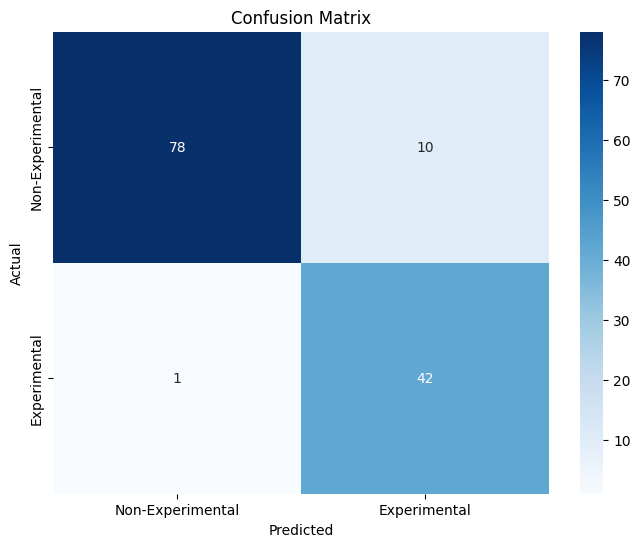

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'YES'/'NO' to True/False in 1st_token column
merged_df['1st_token'] = merged_df['1st_token'].map({'YES': True, 'NO': False})

# Calculate metrics
accuracy = accuracy_score(merged_df['is_exp_by_human'], merged_df['1st_token'])
precision = precision_score(merged_df['is_exp_by_human'], merged_df['1st_token'])
recall = recall_score(merged_df['is_exp_by_human'], merged_df['1st_token'])
f1 = f1_score(merged_df['is_exp_by_human'], merged_df['1st_token'])

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

# Create confusion matrix
cm = confusion_matrix(merged_df['is_exp_by_human'], merged_df['1st_token'])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Experimental', 'Experimental'],
            yticklabels=['Non-Experimental', 'Experimental'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
# Find disagreements between model and human labels
disagreements = merged_df[merged_df['1st_token'] != merged_df['is_exp_by_human']]

# Display results with relevant columns
print("Rows where model and human disagree:")
print(disagreements[['file_name', 'page_number', '1st_token', 'is_exp_by_human', 'text']].to_string())
print(f"\nTotal disagreements: {len(disagreements)}")

Rows where model and human disagree:
         file_name  page_number  1st_token  is_exp_by_human                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

# Chunk size is 1000

In [16]:
def analyze_file_chunk(file_path: str) -> Tuple[str, str]:

    results=[]
    file_name = os.path.basename(file_path)
    absolute_path = os.path.abspath(file_path)
    CLASSIFICATION_PROMPT = """
You are analyzing a chemical patent about olefin polymerization catalysts. Check if this page contains EXPERIMENTAL DATA.

PATENT SECTIONS:
1. EXPERIMENTAL Sections (answer YES):
   - "EXAMPLES"
   - "COMPARATIVE EXAMPLES" 
   - "WORKING EXAMPLES"
   - "PREPARATION EXAMPLES"
   - "POLYMERIZATION EXAMPLES"
   - "TABLES"

2. NON-EXPERIMENTAL Sections (answer NO):
   - "TECHNICAL FIELD"
   - "BACKGROUND ART"
   - "CLAIMS"
   - "ABSTRACT"

ANSWER YES IF YOU SEE:
1. ANY part of experimental procedures (including continued from previous page):
   - Beginning: "The catalyst was prepared by mixing..."
   - Middle: "...was stirred for 2h at 80°C..."
   - End: "...yielding 5.2g of product"
   - Table parts (even incomplete)
   - Continued analytical data

2. Detailed procedures, like:
   "The catalyst was prepared by mixing..."
   "Polymerization was carried out..."
   "To a flask was added..."
   "The mixture was stirred at..."
   "Table №1"

3. ANY measurements:
   Masses: "5.2 g", "10 mg", "2.5 wt%"
   Volumes: "100 ml", "50 μL"
   Temperatures: "25°C", "80 °C"
   Times: "2 h", "30 min"
   Pressures: "5 bar", "0.5 MPa"

4. Results tables with ANY numbers

ANSWER NO IF PAGE ONLY HAS:
- General descriptions without procedures
- Lists of compounds without quantities
- Patent claims
- Theoretical explanations

CRITICAL RULES:
1. Even PARTIAL experimental data makes the page experimental (YES)
2. Beginning, middle, or end of procedures count as experimental
3. Continued tables from previous pages count as experimental
4. Look for procedure descriptions with measurements first!

Answer ONLY "YES" or "NO"

Analyze this text: {text}"""

 # Initialize text splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=0,
        length_function=len,
        separators=["\n\n", "\n", " ", ""]
    )


    with open(file_path, "rb") as f:
        reader = PdfReader(f).pages
        text = []
        for page in reader:
            text.append(page.extract_text())
    
    for i, page in enumerate(text):
        print(f"\nHeadline: {page[:200]}")
        
        # Check if page is empty or contains only whitespace
        if not page.strip():
            top_two_logprobs = [
                SimpleNamespace(token="NO", logprob=0.0),
                SimpleNamespace(token="YES", logprob=float('-inf'))
            ]
        else:
            # Split page into chunks using LangChain
            chunks = text_splitter.split_text(page)
            chunk_responses = []
            
            # Analyze each chunk
            for chunk in chunks:
                chunk_response = get_completion(
                    [{"role": "user", "content": CLASSIFICATION_PROMPT.format(text=chunk)}],
                    model="gpt-4o-mini",
                    logprobs=True,
                    top_logprobs=2,
                    max_tokens=1,
                    temperature=0,
                )
                chunk_responses.append(chunk_response.choices[0].logprobs.content[0].top_logprobs)
        final_decision = "YES" if any(
                response[0].token == "YES" for response in chunk_responses
            ) else "NO"   



        results.append({
                            'file_name': file_name,
                            'file_path': absolute_path,
                            'page_number': i+1,
                            'chunk_based_analysis': final_decision,
                            'text': page
                        })

    df = pd.DataFrame(results)
    df.to_csv(f"/home/anatoly_kayda/Desktop/mipt/kayda_thesis/output_chunk_is_1000/{file_name}_parsed.csv")
    return df


In [17]:
for patent_name, patent_path in best_10_patents_paths.items():
    analyze_file_chunk(patent_path)


Headline: USOO6617405B1 
 (12) United States Patent (10) Patent No.: US 6,617,405 B1 
 Jorgensen (45) Date of Patent: Sep. 9, 2003 
 (54) PROCESS FOR THE PREPARATION OF 5,601,472 A 2/1997 Parker ...............


2025-03-17 20:45:46,857 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:47,472 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:48,178 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 6,617.405 B1 
 1 
 PROCESS FOR THE PREPARATION OF 
 POLYETHYLENE 
 TECHNICAL FIELD 
 This invention relates to a proceSS for the preparation of 
 polyethylene with a focus on catalyst activation. 



2025-03-17 20:45:48,802 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:50,365 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:50,904 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:51,405 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:52,175 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:53,053 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:53,621 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:54,262 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 6,617.405 B1 
 3 
 DISCLOSURE OF THE INVENTION 
 An object of this invention, therefore, is to provide a proceSS for preparing polyethylene, which overcomes the 
 deficiencies associated with Separ


2025-03-17 20:45:54,948 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:55,602 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:56,232 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:56,802 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:57,603 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:58,224 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:45:58,741 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:02,114 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 6,617.405 B1 
 S 
 aluminum, tri-n-hexyl aluminum, dimethyl aluminum chloride, and tri-n-octyl aluminum. Particularly preferred 
 activators are: a Sequential mixture of tri-n-hexylaluminum 
 and d


2025-03-17 20:46:02,856 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:03,597 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:04,259 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:04,788 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:05,512 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:06,180 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:06,790 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:07,839 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:08,332 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: US 6,617.405 B1 
 7 
 bottom of the residence time pot. The impeller promotes Some radial mixing, but mainly assures that the bottom Section of the residence time pot does not experience SuS pended so


2025-03-17 20:46:08,878 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:09,465 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:10,102 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:10,819 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:11,331 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:11,960 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:12,969 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:13,685 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:14,607 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: US 6,617.405 B1 
 9 
 in the range of about 10 to about 150 psig, and is preferably 
 in the range of about >20 to about 120 psig. The balance of the total pressure is provided by alpha-olefin (if use


2025-03-17 20:46:15,118 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:15,900 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:16,539 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:17,347 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:17,986 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:18,470 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:19,107 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:19,783 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 6,617.405 B1 
 11 
 fashion over a larger range of polymer MFR (melt flow ratio), hexane extractables, and polymer bulk density. The Smaller reaction System is used illustratively to avoid experi 



2025-03-17 20:46:20,345 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:21,178 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:21,846 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:22,459 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:23,009 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:23,531 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:24,333 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 6,617.405 B1 
 13 
 TABLE II 
 RESIN PROPERTIES 1. 2 3 4 
 Melt Index, I2 (dg/min) 1.12 1.07 O.90 1.08 
 Density (g/cm3) 91.95 91.82 91.85 91.90 
 MFR 26.2 26.O 26.O 24.9 
 Residual Al (ppm) 32 41 


2025-03-17 20:46:24,894 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:25,647 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:26,206 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:26,802 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:27,432 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 6,617.405 B1 
 TABLE IV-continued TABLE VI(B)-continued 
 Examples Comparative Examples 
 RESIN PROPERTIES 5 6 7 8 9 S RESIN PROPERTIES 5 6 7 8 
 APS (inches) O17 O18 O17 O18 O18 Added Activator/ED


2025-03-17 20:46:28,125 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:28,683 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:29,319 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:29,864 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 6,617.405 B1 
 17 
 aliphatic hydrocarbon radical having 1 to 14 carbon 
 atoms, each X is independently chlorine, bromine, or 
 iodine, and n is 1 to 3; and 
 (iv) no additional activator is intro


2025-03-17 20:46:30,604 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:31,354 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: USOO6248831B1 
 (12) United States Patent (10) Patent No.: US 6,248,831 B1 
 Maheshwari et al. (45) Date of Patent: Jun. 19, 2001 
 (54) HIGH STRENGTH POLYETHYLENE FILM (56) References Cited 
 (75) In


2025-03-17 20:46:32,735 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:33,346 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 6,248,831 B1 
 1 
 HIGH STRENGTH POLYETHYLENE FILM 
 TECHNICAL FIELD 
 This invention relates to a process for preparing an in Situ polyethylene blend, which can be converted into film having an im


2025-03-17 20:46:34,063 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:34,821 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:35,435 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:36,213 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:36,827 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:37,338 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:37,894 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:38,399 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:39,178 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: US 6,248,831 B1 
 3 
 Strength, particularly in terms of dart drop. Other objects and 
 advantages will become apparent hereinafter. 
 According to the present invention Such a proceSS for the 
 produ


2025-03-17 20:46:40,207 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:40,762 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:41,253 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:42,025 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:42,761 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:43,267 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:44,014 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:44,507 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 6,248,831 B1 
 S 
 Sometimes, e.g., with high density polyethylene, the bubble 
 looks like a cylindrical Semi-molten tube with a diameter approximately equal to the ring diameter before being blow


2025-03-17 20:46:45,020 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:45,505 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:46,050 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:46,579 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:47,110 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:47,704 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:48,393 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:49,115 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:49,592 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: US 6,248,831 B1 
 7 
 interconnecting device using nitrogen or Second reactor recycle gas as a transfer medium. 
 In the high molecular weight (HMW) reactor: 
 Because of the low values, instead of me


2025-03-17 20:46:51,039 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:51,675 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:52,392 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:52,932 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:53,435 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:53,963 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:54,544 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:55,168 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:55,751 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: US 6,248,831 B1 
 the cocatalyst Solution. Optionally, the liquid cocatalyst can be fed directly to the fluidized bed. The partially activated catalyst precursor is preferably injected into the fluidi


2025-03-17 20:46:57,022 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:57,614 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:58,178 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:58,892 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:46:59,662 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:00,380 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:00,993 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:01,725 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:02,397 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: US 6,248,831 B1 
 11 
 To a 10 gallon Stainless Steel reaction/filter vessel are charged 1,892 grams of magnesium/titanium alkoxide pre 
 cursor powder together with 3.5 kilograms of hexane. Then, a s


2025-03-17 20:47:03,109 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:04,066 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:04,746 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:05,499 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:06,004 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:06,551 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:07,134 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:07,638 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: reaction 
 conditions 
 temperature(C.) pressure (psia) 
 COOOle 
 C2 partial pressure(psia) 
 H2/C2 molar 
 ratio 
 C6/C2 
 molar ratio 
 recycle isopentane 
 (mol%) C2 feed (Ibs/hr) catalyst feed 
 


2025-03-17 20:47:08,161 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:08,919 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:09,412 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:10,007 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 6,248,831 B1 
 15 
 The SECs reveal that the examples 2 and 3 products have 
 a broader molecular weight distribution than the example 1 
 product. It is noted that the broadening occurs in the hig


2025-03-17 20:47:10,618 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:11,177 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:11,729 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:12,307 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:12,974 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 17 
 TABLE X-continued 
 reaction 
 conditions 
 production rate 
 for each reactor 
 (Ibs/hr) bed weight (Ibs) 
 fluidized bulk 
 density 
 (Ibs/cu ft) 
 bed volume 
 (cu ft) 
 residence time 
 (hrs)


2025-03-17 20:47:13,487 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:14,175 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:14,921 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:15,636 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 6,248,831 B1 
 TABLE XII-continued 
 reaction first second 
 conditions reactor reactor 
 (wt %) 
 fines less than O.21 O.53 
 120 mesh (wt %) 
 Notes to above Tables: 
 1. Resin properties for Sec


2025-03-17 20:47:16,251 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:16,767 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:17,377 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:17,906 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:18,784 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:19,489 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:20,015 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:20,729 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 6,248,831 B1 
 21 
 8. The process defined in claim 7 wherein the blend has a melt index (I5) in the range of about 0.1 to about 0.6 grams per 10 minutes; a melt flow ratio (I 21.6/I 5) in the rang


2025-03-17 20:47:21,678 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:22,218 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:25,406 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:25,994 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:26,547 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: (19) United States US 20060046928A1 
 (12) Patent Application Publication (10) Pub. No.: US 2006/0046928A1 
 Klendworth et al. (43) Pub. Date: Mar. 2, 2006 
 (54) ZIEGLER-NATTA CATALYST AND METHOD (52


2025-03-17 20:47:27,718 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:28,232 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: Patent Application Publication Mar. 2, 2006 Sheet 1 of 3 US 2006/0046928A1 
 G.   


2025-03-17 20:47:28,846 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: Patent Application Publication Mar. 2, 2006 Sheet 2 of 3 US 2006/0046928A1 
 O. 2   


2025-03-17 20:47:29,460 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0046928A1 Mar. 2, 2006 Sheet 3 of 3 Patent Application Publication 
 3 O.   


2025-03-17 20:47:30,016 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0046928A1 
 ZEGLER-NATTA CATALYST AND METHOD FOR 
 MAKING AND USING SAME 
 FIELD OF THE INVENTION 
 0001. The present invention relates to catalysts, and par ticularly to Ziegler-Natta catalys


2025-03-17 20:47:30,717 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:31,508 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:32,236 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:32,730 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:33,563 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:34,218 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:34,983 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0046928A1 
 from about 0.5 wt % to about 3.0 wt % of the silica seeding agent is used relative to the magnesium-halide compound. 
 Generally, a higher ratio of magnesium-halide to Silica 
 See


2025-03-17 20:47:35,605 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:36,174 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:36,832 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:37,450 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:38,010 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:38,640 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:39,652 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:40,518 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0046928A1 
 include mono- and polyfunctional carboxylic acids, car boxylic anhydrides and carboxylic esters, and ketones, 
 ethers, alcohols, lactones as well as organic phosphorus and 
 Silic


2025-03-17 20:47:41,178 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:41,952 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:42,917 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:43,508 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:44,005 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:44,527 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:45,212 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:45,758 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0046928A1 
 sium hydroxide and iodomagnesium hydroxide. Among 
 these compounds the magnesium dihalides corresponding to 
 the formula MgX are preferred wherein X is a halogen. Especially pref


2025-03-17 20:47:46,561 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:47,280 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:47,885 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:48,608 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:49,325 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:50,218 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:50,950 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0046928A1 
 due to the difficulty in finding Such a Single Substance, most polypropylene catalysts employ two separate Substances for 
 their internal and external electron donors. 
 0044 Pref


2025-03-17 20:47:51,434 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:52,295 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:53,040 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:53,851 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:54,540 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:55,267 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:55,878 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0046928A1 
 0056 Next, the solid catalyst Support particles were 
 added slowly to a third flask containing 200 ml of neat TiCl, 
 which had been pre-cooled to about 0° C. After the tem peratu


2025-03-17 20:47:56,425 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:57,004 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:57,703 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:58,232 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:58,950 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:47:59,463 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:00,207 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:00,794 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0046928A1 
 1133 at a temperature of 230 C. and under a load of 2.06 kg. Certain applications might require different molecular 
 weights than those mentioned above and are contemplated to be 


2025-03-17 20:48:01,305 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:02,125 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:02,675 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:03,395 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:03,860 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:05,037 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:05,796 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0046928A1 
 17. The method of making a magnesium-halide Support 
 according to claim 14, wherein the alkanol is Selected from the group consisting of ethanol, methanol and 2-ethyl-1- 
 hexanol


2025-03-17 20:48:06,394 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:07,049 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:07,652 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:08,232 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:08,935 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:12,979 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: United States Patent (19) 
 Werner et al. 
 54 PREPARATION OF HOMO- AND COPOLYMERS OF PROPENE USINGA 
 ZEGLER-NATTA CATALYST SYSTEM 
 Rainer A. Werner, Bad Durkheim; Ralf Zolk, Hessheim, both of Fed. 


2025-03-17 20:48:13,720 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:14,435 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:14,917 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,843,132 1. 
 PREPARATION OF HOMO- AND COPOLYMERS 
 OF PROPENE USINGAZEGLER-NATA 
 CATALYST SYSTEM 
 The present invention relates to a process for the preparation of homopolymers of propene and copo


2025-03-17 20:48:15,520 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:16,153 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:16,659 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:17,280 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:18,099 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:18,818 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:19,505 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:19,977 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,843,132 3 
 where R is an aryl, alkylaryl or alkyl radical of not more than 16, preferably not more than 10, carbon atoms, in particular phenyl, tolyl or ethylphenyl, R2 is 
 alkyl of not more than 


2025-03-17 20:48:25,269 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:27,496 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:28,041 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:28,805 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:29,539 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:30,171 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:30,680 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:31,218 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:32,742 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,843,132 5 
 weight of the titanium tetrachloride being used per 10 parts by weight of the solid-phase intermediate obtained from the first stage, and finally (1.3) in a third stage, the solid-phase 


2025-03-17 20:48:33,326 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:33,820 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:34,329 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:35,182 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:35,829 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:36,303 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:36,977 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:37,759 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:38,363 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,843,132 7 
 resulting solid is then isolated by filtration and washed with n-heptane to give the carrier (III), 
 (IV) titanium tetrachloride and (V) phthaloyl dichloride, in such a way that first (


2025-03-17 20:48:39,451 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:40,012 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:40,627 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:41,215 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:41,915 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:42,519 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:43,085 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:43,645 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:44,363 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,843,132 
 resulting solid-phase intermediate is isolated by filtra tion, and finally (1.3) in a third stage, the solid-phase intermediate obtained in the second stage is extracted with n-heptane 10 


2025-03-17 20:48:45,821 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:46,507 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:47,077 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:47,761 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:48,704 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:49,175 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,843,132 11 
 where X and Y together form oxygen or X and Y are each chlorine or C1-C10-alkoxy, in such a way 
 that first 
 either (a) (1.1.1.a) in a first substage, the magnesium chloride (I) 
 and


2025-03-17 20:48:49,796 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:50,341 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:50,811 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:51,400 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: United States Patent (19) 
 Strobel et al. 
 (54) PROCESS FOR THE PREPARATION OFA CATALYST AND CATALYST USED IN OLEFN POLYMERZATION 
 75) Inventors: Wolfgang Strobel, Hofheim; Rainer Franke, Frankfurt


2025-03-17 20:48:52,648 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:53,348 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,148,754 1. 
 PROCESS FOR THE PREPARATION OFA 
 CATALYST AND CATALYST USED IN OLEFN 
 POLYMERZATION 
 The present invention relates to the preparation of a catalyst for the polymerization of ethylene


2025-03-17 20:48:54,046 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:54,649 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:55,335 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:55,834 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:56,396 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:56,975 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:57,488 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:58,197 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:48:58,755 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,148,754 3 Suitable halogen-containing magnesium-organic compounds are compounds of the formula RMgX, in which R is a hydrocarbon radical having from 1 to 20, preferably from 2 to 10 carbon atoms and


2025-03-17 20:49:00,600 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:01,367 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:02,436 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:02,899 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:04,115 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:04,714 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:05,332 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:06,021 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:06,692 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,148,754 
 wherein R2 and R2 is hydrogen, an alkyl radical, an alkylene radical having a non-terminal double bond or a mononuclear aryl radical and a is 0 or 1, are used prefer ably. There may be men


2025-03-17 20:49:07,660 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:08,376 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:08,994 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:09,714 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:10,538 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:11,416 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:11,944 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:12,459 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,148,754 7 
 ous phase in a fluidized bed. The use of oxide carriers having a particle size of more than 30 Jum, which may be obtained for example by separating fine particles by sieving, prevents fi


2025-03-17 20:49:12,957 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:13,542 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:14,195 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:14,996 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:15,546 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:16,165 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:16,727 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:17,207 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,148,754 
 weight below 50 m. 125,000 g of polyethylene per gram of titanium and 5,809 g of polyethylene per gram of the catalyst component A are obtained. 
 COMPARATIVE EXAMPLE A 
 The example demon


2025-03-17 20:49:17,701 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:18,293 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:18,835 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:19,354 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:20,001 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:20,594 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:21,154 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:21,661 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:22,916 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,148,754 11 
 EXAMPLE 7 
 Into a 1 liter autoclave made from stainless steel there 
 are introduced 500 ml of Diesel oil, and the air is dis placed by evacuating and by introducing nitrogen 5 
 under


2025-03-17 20:49:23,531 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:24,024 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:24,964 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:26,061 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:26,726 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:27,239 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:27,833 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:28,453 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:28,941 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,148,754 3 polyethylene, per gram of the catalyst component A, 330 g. 
 EXAMPLE 11 
 Ethylene is polymerized under the conditions de scribed in Example 4 in the presence of 0.62 g of the catalyst com


2025-03-17 20:49:29,977 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:30,533 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:31,026 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:31,756 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:32,439 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:33,054 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:33,594 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:34,180 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,148,754 5 ity of the powder 0.077 cm3-sec/g. Pergram of titanium there are obtained 12,700 g, per gram of the component A, 467 g, of polyethylene. 
 EXAMPLE 19 
 A porous aluminum silicate (85.7% of


2025-03-17 20:49:34,675 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:35,204 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:35,769 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:36,433 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:37,148 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:37,766 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:38,316 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:39,037 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:39,882 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,148,754 17 
 14. A compound prepared according to the process as 
 defined in claim 13. 
 15. A process as defined in claim 1, wherein R* and R6 are alkyl of from 1 to 16 carbon atoms. 16. A compoun


2025-03-17 20:49:40,790 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:41,434 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:42,164 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: United States Patent (19) 
 Nowlin et al. 
 54 
 75 
 (73) 
 (21) 
 22 
 (63) 
 51 (52) 
 (58) 
 56) HIGHILY ACTIVE CATALYST 
 COMPOSITION FOR POLYMERIZNG 
 ALPHA-OLEFNS 
 Inventors: Thomas E. Nowlin,


2025-03-17 20:49:43,499 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:44,070 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: U.S. Patent Nov. 6, 1984 Sheet 1 of 5 4,481,301 
 GAS RECYCLE 
 INERT GAS 
 GAS FEED 
   


2025-03-17 20:49:44,625 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 

Headline: 4,481,301 Sheet 3 of 5 U.S. Patent Nov. 6, 1984 
 LSÅTVLVO Z'XE DE LSÅTVIVO y o Oi LV8 ZO/#70 SA Å LISNEC] 
 MSNBC OO/SWWS)   


2025-03-17 20:49:45,239 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: U.S. Patent Nov. 6, 1984 Sheet 4 of 5 4,481,301 
 ON 
 GN 
 O N s 9 a. s 
 V & al 3 s cos O g s 
 N L. Q s cos 2 v C) 
 C O) S 
 OO/SWWOALISN3O s   


2025-03-17 20:49:45,852 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 

Headline: 4,481,301 
 HGHLY ACTIVE CATALYST COMPOSITION 
 FOR POLYMERIZING ALEPHA-OLEFNS 
 CROSS REFERENCE TO RELATED 
 APPLICATION 
 This application is a continuation-in-part of U.S. ap 
 plication Ser. No. 3


2025-03-17 20:49:46,559 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:47,589 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:48,084 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:48,597 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:49,118 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:49,950 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:50,480 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:51,347 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,481,301 3 (i) contacting a solid, porous carrier having reactive OH groups with a liquid in the absence of ball milling, said liquid containing at least one organomagnesium composition having the em


2025-03-17 20:49:52,071 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:52,604 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:53,197 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:53,842 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:54,331 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:54,810 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:55,480 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:56,032 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,481,301 5 Chemically bound water, as represented by a pres ence of OH groups in the carrier, may be present when the carrier is contacted with water-reactive magnesium compounds in accordance with a


2025-03-17 20:49:56,754 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:57,286 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:58,009 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:58,608 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:49:59,349 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:00,124 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:00,924 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:01,656 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,481,301 
 C2H5 
 O 
 Although organomagnesium compounds of the for 
 mula RMgX tend to be insoluble in non-Lewis base solvents such as hexane, these organomagnesium com pounds may be completely solu


2025-03-17 20:50:02,442 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:03,043 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:03,767 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:04,288 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:05,237 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:06,078 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:06,615 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:07,191 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:07,657 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,481,301 
 may, optionally, be in the form of a complex with one or more electron donating agents (i.e. Lewis bases). More particularly, when ethylmagnesium chloride is precipi tated from a hexane/te


2025-03-17 20:50:08,339 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:08,868 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:09,494 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:10,242 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:11,044 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:11,645 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:12,130 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:12,802 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:13,330 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,481,301 11 
 alkoxide portion thereof is a C1-C6 alkoxide), or mix tures thereof. A preferred tetravalent titanium com pound is TiCl4. It may also be possible to replace some or all of the above-men


2025-03-17 20:50:16,163 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:16,704 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:17,276 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:17,883 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:18,572 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:19,077 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:19,570 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:20,057 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:20,602 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,481,301 13 
 certain aspects of the present invention is felt to be sufficient to produce a linear low density polyethylene polymer which is an ethylene/1-hexene copolymer, e.g., having a density of


2025-03-17 20:50:21,185 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:21,902 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:22,437 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:23,021 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:23,488 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:24,003 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:24,709 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:25,275 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:26,437 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,481,301 15 
 fluidized bed through distribution plate 20. The com pressor 25 can also be placed upstream of the heat ex changer 26. The distribution plate 20 plays an important role in the operation


2025-03-17 20:50:29,583 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:30,101 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:30,600 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:31,120 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:31,595 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:32,143 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:32,839 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:33,323 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:33,888 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,481,301 17 
 is then opened to deliver the product to an external recovery zone. Valve 38 is then closed to await the next product recovery operation. 
 Finally, the fluidized bed reactor is equippe


2025-03-17 20:50:36,343 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:36,840 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:37,464 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:38,083 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:38,699 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:39,259 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:39,825 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:41,054 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:41,562 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,481,301 19 
 substantially in accordance with this Karol et al patent are referred to herein as "comparative A' catalysts or simply as 'A' catalysts. The comparative A catalysts are felt to be subst


2025-03-17 20:50:42,329 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:43,082 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:43,728 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:44,491 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:45,127 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:45,628 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:46,173 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,481,301 21 I2 melt index level over a range of magnesium loadings into Davison 952 silica dried at 200 C. 
 If silica dried at 800 C, is used in place of silica dried at 200 C., the copolymerization


2025-03-17 20:50:46,961 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:47,493 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:48,050 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:48,781 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:49,555 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:50,110 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:50,579 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,481,301 23 The catalyst of Example 2 may generate about four times as much heat (per area of catalyst particle) as the Example 6 catalyst. This extra heat could result in se vere temperature gradien


2025-03-17 20:50:51,707 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:52,338 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:52,935 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:53,419 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:54,163 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:54,882 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:55,394 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,481,301 25 
 COMPARATIVE EXAMPLE B 
 The catalyst of this Comparative Example was pre pared in accordance with Example 7 of the Yamaguchi 
 et al U.S. Pat. No. 3,989,881. One will readily note the s


2025-03-17 20:50:56,110 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:56,617 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:57,454 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:58,213 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:58,980 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:50:59,688 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:00,486 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,481,301 27 28 
 TABLE IX-continued 
 COMPARISON OF EX.8 CATALYST WITH BAND C 
 Run Identification Polymerization Conditions" Product Obtained 
 Catayst Cat. Wt. H2 Total P TEAL Al/Ti Hexene Density 


2025-03-17 20:51:00,965 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:02,080 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:02,765 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:03,278 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:03,782 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:04,295 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,481,301 29 moles of said organomagnesium composition to the number of moles of OH groups on said silica being from about 1.1 to about 2.5, whereby said or ganomagnesium composition is reacted with s


2025-03-17 20:51:05,067 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:05,634 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:06,205 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:06,768 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:07,429 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:07,974 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:08,688 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:09,231 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:09,834 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: UNITED STATES PATENT AND TRADEMARK OFFICE 
 CERTIFICATE OF CORRECTION 
PATENT NO. : 4,481,301 Page 1 of 2 
 DATED : November 6, 1984 
INVENTOR(S) : T.E. NOWLIN, and K.P. WAGNER 
 It is Certified that 


2025-03-17 20:51:10,445 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:11,005 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: — 
 UNITED STATES PATENT AND TRADEMARK OFFICE 
 CERTIFICATE OF CORRECTION 
PATENT NO. 
DATED 
INVENTOR(S) : 
 It is Certified that error appears in the above-identified patent and that said Letters Pa


2025-03-17 20:51:11,566 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:12,247 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: United States Patent (19) 
 Nowlin et al. 
 54 
 75 
 73) 
 (21) 
 22) 
 51 (52) 
 (58) 
 56) CATALYST COMPOSITION FOR 
 POLYMERZNG ALPHA-OLEFIN 
 POLYMERS OF NARROW MOLECULAR 
 WEIGHT DISTRIBUTION 
 


2025-03-17 20:51:13,355 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:14,033 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:14,526 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: U.S. Patent Jul.18, 1989 Sheet 1 of 4 4,849,389 
 s N l 
 f i 
 s 
 (SONWSOHL) (OHILWO W9I SWW.9) 
 MINO?OOld   


2025-03-17 20:51:15,176 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: U.S. Patent Jul.18, 1989 Sheet 2 of 4 4,849,389 
 MFR vs -HEXENE CONTENT . 34 TEAL OR TMA AS COCATALYST - CATALYST OF EXAMPLE 
 30 u ul-F 28 u- - 
 2O 2 2.4 2.8 3.2 3.6 4.0 4.4 4.8 
 -HEXENE CONTENT I


2025-03-17 20:51:15,806 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: U.S. Patent Jul.18, 1989 Sheet 3 of 4 4,849,389 
 N 7 EFFECT OF DRYING TEMPERATURE 
 PRODUCTIVITY WITH TEAL OR TMA 
 2 TEAL 
 NTMA. 
 DRY 90'C U DRY 55 DRYING TEMPERATURE FIG. 
 CORRELATION BETWEEN MF


2025-03-17 20:51:16,294 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: U.S. Patent Jul.18, 1989 Sheet 4 of 4 4,849,389 
 CORRELATION BETWEEN MFR AND TMA CONCENTRATION 
 FOR A COMPARATIVE CATALYST (EXAMPLE 15B) AND THE INVENTIVE CATALYST (EXAMPLE: SMILAR TO 
 EXAMPLE I) 



2025-03-17 20:51:16,821 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,849,389 1. 
 CATALYST COMPOSITION FOR 
 POLYMERIZING ALPHAOLEFN POLYMERS 
 OF NARROW MOLECULAR WEIGHT 
 DISTRIBUTION 
 BACKGROUND OF THE INVENTION 
 1. Field of the Invention 
 The present invention


2025-03-17 20:51:17,734 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:18,470 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:19,358 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:19,944 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:20,477 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:21,171 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:21,695 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:22,152 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,849,389 3 
 as publication No. 0231102, disclose an alpha-olefin polymerization catalyst composition activated with trimethylaluminum which produces polymers having 
 relatively low values of MRF an


2025-03-17 20:51:22,826 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:23,522 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:24,172 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:25,044 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:25,707 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:26,324 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:26,934 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,849,389 5 
 into the solvent, preferably while stirring, and heating the mixture is about 25 to about 100 C., preferably about 40 to about 60° C. The slurry is then contacted with the aforementioned


2025-03-17 20:51:27,504 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:28,161 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:28,985 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:29,491 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:32,977 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:33,466 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:34,209 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:35,101 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:36,231 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,849,389 7 
 injection molding products which are resistant to warp ing or shrinking. 
 Suitable transition metal compounds used herein are compounds of metals of Groups IVA, VA, VIA or VIII of the P


2025-03-17 20:51:37,607 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:38,173 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:38,689 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:39,534 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:40,234 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:40,809 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:41,373 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:42,135 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:42,671 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,849,389 9 
 known to those skilled in the art, such MFR values are indicative of a relatively narrow molecular weight dis tribution of the polymer. As is also known to those skilled in the art, such


2025-03-17 20:51:43,178 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:43,668 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:44,289 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:45,065 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:45,663 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:46,192 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,849,389 11 
 heated to about 80° C. under purge of dry nitrogen, was filled with 400 mls of dry hexane, 200 mls of dry 1-hex ane and 3.0 mls of triethylaluminum (25 wt % in hex 
 ane). The reactor w


2025-03-17 20:51:46,705 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:47,359 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:48,137 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:48,743 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:49,502 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:50,062 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:50,667 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,849,389 13 catalyst precursor was injected with ethylene overpres 
 sure. The temperature was maintained at 80 C. and 150-200 grams of copolymer was produced in 50-60 
 minutes. The effect of increa


2025-03-17 20:51:51,228 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:51,821 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:52,342 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:52,948 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:53,699 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:54,425 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,849,389 15 
 The data indicate that the productivity of this catalyst precursor is particularly sensitive to the drying condi 
 tions. The precursor dried at 55 C. is about 25 percent more productiv


2025-03-17 20:51:55,701 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:56,423 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:57,058 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:57,524 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:58,277 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:58,884 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,849,389 17 
 (iii) contacting the slurry of step (ii) with at least one transition metal compound soluble in the non-polar 
 solvent; and (iv) combining the product of step (iii) with trimethyl 
 al


2025-03-17 20:51:59,372 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:51:59,915 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:00,437 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:01,033 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:02,216 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:02,753 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:03,292 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: United States Patent (19) 
 Pullukat et al. 
 (54) 
 (75) 
 73) 
 21) 
 22) 
 (51) (52) (58) 
 (56) POLYMERIZATION CATALYST AND 
 METHOD 
 Inventors: Thomas J. Pullukat, Hoffman Estates; Raymond E. Ho


2025-03-17 20:52:04,120 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:04,638 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:05,196 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: ; 4,374,753 1 
 POLYMERIZATION CATALYST AND METHOD 
 BACKGROUND OF THE INVENTION 
 In this invention, the polymerization catalysts useful in polymerizing and copolymerizing 1-olefins are pre 
 pared b


2025-03-17 20:52:05,745 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:06,568 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:07,392 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:08,137 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:08,753 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:09,495 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:10,093 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:10,772 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,374,753 3 rotational molding applications can be manufactured. The catalysts of this invention are stable, particulate, 
 and easy flowing. . . . . - 
 The alcohol modification allows the production


2025-03-17 20:52:11,488 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:12,100 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:13,025 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:13,706 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:14,558 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:15,172 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:15,640 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:16,280 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:16,969 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: 4,374,753 
 RSixn 
 where m is 1, 2 or 3, n is 3, 2 or 1, respectively, and the total of m--n=4, X is a group chemically reactive with the hydroxyl groups of the silica or alumina such as chloride, am


2025-03-17 20:52:17,735 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:18,556 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:19,103 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:19,604 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:20,195 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:21,013 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:21,796 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:22,322 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,374,753 7 
 atmospheric to 10,000 psi gauge. It is carried out prefer ably under the technically interesting pressure in the 
 range of from 300-800 psi. The melt index of the polyethylene produced 


2025-03-17 20:52:23,029 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:23,801 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:24,408 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:24,913 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:25,721 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:26,391 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:26,879 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,374,753 9 
 -continued 
 Reactivity Melt 
 g/g cat/hr index 
 Catalyst 4190 . 1.4 
 EXAMPLE'S 
 A catalyst was made in the same manner as described in Example 1 except that a different magnesium com


2025-03-17 20:52:27,748 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:28,280 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:28,896 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:29,590 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:30,230 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:30,844 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:31,453 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,374,753 
stage, volatile materials were evaporated in a nitrogen 11 
stream by immersing the flaskin a bath at 100° C. Upon cooling, 15 ml hexane and 3.9 ml of dibutyl magnesium triethylaluminum com


2025-03-17 20:52:32,184 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:32,688 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:33,198 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:33,724 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:34,265 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:34,941 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:36,622 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: 4,374,753 13 
 3. The catalyst of claim 1 wherein said Group IIA compound or complex of (2) comprises an alkyl or aryl of magnesium or a magnesium complex. 
 4. The catalyst of claim 1 wherein said al


2025-03-17 20:52:37,441 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:38,182 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:38,670 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:39,208 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:39,742 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:40,261 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:40,963 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: (12) United States Patent 
 Braganca et al. US0093.52308B2 
 US 9,352,308 B2 
 May 31, 2016 (10) Patent No.: 
 (45) Date of Patent: 
 (54) SOLID CATALYST COMPONENT FOR 
 POLYMERIZATION AND 
 COPOLYMER


2025-03-17 20:52:42,108 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:43,135 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:43,621 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: U.S. Patent May 31, 2016 Sheet 1 of 6 US 9,352,308 B2 
 FIGURE 1 
 Organometallic 
 compound solution Silica-o- IMPREGNATION 
 (a) 
 Magnesium compound 
 REACTON REMOVAL Supernatant Titanium compound 


2025-03-17 20:52:44,350 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: U.S. Patent May 31, 2016 Sheet 2 of 6 US 9,352,308 B2 
 FIGURE 2 
   


2025-03-17 20:52:45,134 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 9,352,308 B2 U.S. Patent 
 9/ | 
 eoueoeye   


2025-03-17 20:52:45,666 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: U.S. Patent May 31, 2016 Sheet 4 of 6 US 9,352,308 B2 
 FIGURE 4 
 .. 
 O 
 44 4, 48 SO SO. 54 SO 58 
 Energy (ew 


2025-03-17 20:52:46,263 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: U.S. Patent May 31, 2016 Sheet 5 of 6 US 9,352,308 B2 
 FIGURES 
 9. - 
 O 
 95 . ... 3 498 Energy (W) 
 4.94 EO 498 SO SO SO4 SOSO SO.8 SO 
 Energy (ew)   


2025-03-17 20:52:46,812 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: U.S. Patent May 31, 2016 Sheet 6 of 6 US 9,352,308 B2 
 FIGURE 6 
 1966 968 9FO 9. 94 496 498 98) 
 Energy (EW) 


2025-03-17 20:52:47,540 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 9,352,308 B2 
 1. 
 SOLID CATALYST COMPONENT FOR 
 POLYMERIZATION AND 
 COPOLYMERIZATION OF ETHYLENE AND 
 PROCESS FOR OBTAINING THE SAME 
 This application is a Continuation-In-Part of application


2025-03-17 20:52:48,047 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:48,664 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:49,381 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:50,004 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:50,713 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:51,338 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:51,942 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:52,716 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 9,352,308 B2 
 3 
 groups 1, 2, 12 or 13 of the periodic table. The process for 
 producing the catalyst of the present invention comprises the 
 steps of: 
 (a) impregnating activated silica parti


2025-03-17 20:52:53,259 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:53,941 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:54,661 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:55,394 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:55,941 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:56,666 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:57,299 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 9,352,308 B2 
 5 
 over a period from 1 to 20 hours. The amount of remaining 
 OH on the silica surface after this treatment ranges from 0.1 to 2 mmoles OH per g of silica, preferably between 0.5 a


2025-03-17 20:52:58,181 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:58,697 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:59,201 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:52:59,741 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:00,235 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:00,848 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:01,464 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:02,218 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:02,756 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "


Headline: US 9,352,308 B2 
 7 
 Other silicon compounds useful as reducing agents in the 
 practice of this invention are: silanes (SiH, in which m is a number equal to or higher than 1), alkyl-silanes or aryl 


2025-03-17 20:53:03,410 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:03,974 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:04,537 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:05,227 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:05,871 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:06,687 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:07,305 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:07,917 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 9,352,308 B2 
 The amount of organometallic compound of the groups 1, 
 2, 12 or 13 that remains fixed on the solid catalyst component may reach up to 5% by weight, expressed as the metal con 
 ten


2025-03-17 20:53:08,483 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:09,188 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:09,916 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:10,547 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:11,174 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:11,809 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:12,381 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 9,352,308 B2 
 11 
 anhydrous MgCl, and 330 ml (0.969 moles) of Ti(OBu). 
 This mixture was allowed to stir at 300 rpm and heated to 150° 
 C. for about 12 hours in order to have the solids complet


2025-03-17 20:53:13,431 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:14,059 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:14,562 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:15,057 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:15,801 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:16,550 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:17,307 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:17,887 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 9,352,308 B2 
 13 
 anhydrous MgCl2 and 39.6 ml (0.116 moles) of Ti(OBu). 
 This mixture was allowed to stir at 300 rpm and heated to 150° 
 C. for about 12 hours in order to have the solids comple


2025-03-17 20:53:18,417 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:18,947 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:19,755 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:20,971 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:21,511 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:22,312 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:22,782 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:23,488 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 9,352,308 B2 
 15 
 addition, stirring was continued for 3.5 hours at a temperature of 60°C. The temperature of the mixture was then brought to 
 65° C. and kept for additional 2 hours. After cooli


2025-03-17 20:53:24,022 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:24,786 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:25,343 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:26,040 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:26,593 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:27,170 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 9,352,308 B2 
 17 
 C. for about 12 hours in order to have the solids completely 
 dissolved, thereby a clear liquid product was obtained. This 
 resulting liquid was cooled down to 40°C. and under


2025-03-17 20:53:27,765 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:28,393 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:29,014 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:29,519 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:30,156 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:30,704 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:31,334 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 9,352,308 B2 
 19 
 MIE 0.91 g/10 min 
 MIFAMIE 26 
 Fraction Soluble in Xylene 9.2% 
 Comonomer content 8.7% Polymer Density 0.917 g/cm Bulk Density 0.36 g/cm 
 Pilot Plant Tests 
 A pilot plant c


2025-03-17 20:53:31,880 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:32,610 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:33,212 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:33,937 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:34,749 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:35,590 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 9,352,308 B2 
 21 
 FIG.3 and an X-Ray Absorption Near Edge Structure spectra 
 as shown in one or more of FIGS. 4, 5 and 6. 2. The catalyst composition of claim 1, wherein the product of the homop


2025-03-17 20:53:36,063 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: (19) United States US 2006O166812A1 
 (12) Patent Application Publication (10) Pub. No.: US 2006/0166812 A1 Braganca et al. (43) Pub. Date: Jul. 27, 2006 
 (54) SOLID CATALYST COMPONENT FOR 
 POLYMERI


2025-03-17 20:53:37,417 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:38,175 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:39,074 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: Patent Application Publication Jul. 27, 2006 Sheet 1 of 2 US 2006/0166812 A1 
 FIGURE 1 
 Organometallic 
 o Compound solution Silica-D- IMPREGNATION 
 (a) Magnesium compound 
 REACTION REMOVA Superna


2025-03-17 20:53:39,584 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: Patent Application Publication Jul. 27, 2006 Sheet 2 of 2 US 2006/0166812 A1 
 FIGURE 2 
   


2025-03-17 20:53:40,253 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0166812 A1 
 SOLID CATALYST COMPONENT FOR 
 POLYMERIZATION AND COPOLYMERIZATION 
 OF ETHYLENE, AND, PROCESS FOR OBTAINING 
 THE SAME 
 0001. The present invention relates to a solid catalyst c


2025-03-17 20:53:40,791 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:41,349 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:41,949 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:42,477 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:43,037 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:43,601 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:44,385 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0166812 A1 
 polyethylene with 0.919 g/ml of polymer density has a 
 xylene soluble content of 12.5% by weight. 
 SUMMARY OF THE INVENTION 
 0023 The present invention relates to a solid catal


2025-03-17 20:53:45,003 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:45,632 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:46,847 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:47,628 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:50,906 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:51,478 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0166812 A1 
 0048 (e) optionally reacting the solid obtained in (d) with a reducing agent; 
 0049 (f) reacting the solid obtained in (d) or (e) with a halogenating agent; 
 0050 (g) treating t


2025-03-17 20:53:51,962 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:52,547 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:53,721 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:54,312 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:53:58,111 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:01,358 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:02,230 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:02,812 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0166812 A1 
 0064. In general, when preparing the solution of the step 
 (c), titanium is used in Such an amount that the molar ratio Ti/Mg varies within the range of 0.3 to 4, and preferably 


2025-03-17 20:54:03,426 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:04,019 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:04,652 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:05,197 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:06,498 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:07,349 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:07,990 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:08,559 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0166812 A1 
 or more organometallic compounds of the groups 1, 2, 12 or 13 of the periodic table, preferably metal-alkyl compounds 
 or metal-alkyl halide compounds belonging to these groups, 


2025-03-17 20:54:09,156 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:09,915 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:10,467 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:10,987 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:11,571 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:12,129 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:12,736 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:13,288 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0166812 A1 
 alpha-olefins having from 3 to 14 carbon atoms, having a 
 content of units derived from ethylene greater than approxi mately 80% by weight. These products have improved 
 propert


2025-03-17 20:54:14,036 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:14,896 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:15,515 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:16,249 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:16,839 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:17,336 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0166812 A1 
 moles) of anhydrous MgCl2 and 39.6 ml (0.116 moles) of 
 Ti(OBu). This mixture was allowed to stir at 300 rpm and 
 heated to 150° C. for about 12 hours in order to have the 
 sol


2025-03-17 20:54:17,968 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:18,598 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:19,078 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:19,608 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:20,264 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:21,038 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:21,652 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0166812 A1 
 0146 The chemical and physical characteristics of the resulting reddish powder were as follows: 
 0147 Total Titanium=1.5% (by weight) 
 0148 Mg=0.3% (by weight) 
 0149 SiO,-81.2%


2025-03-17 20:54:22,229 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:22,836 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:23,363 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:24,008 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:24,730 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:25,471 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:26,027 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0166812 A1 
 room temperature, the stirring was stopped to have the Solid 
 settled. The Supernatant liquid was removed, the Solid was 
 repeatedly washed with anhydrous hexane and then dried 


2025-03-17 20:54:26,568 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:27,508 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:28,311 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:28,815 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:29,462 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:29,993 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0166812 A1 
 obtained. This resulting liquid was cooled down to 40° C. 
 and under gently stirring at 150 rpm, it was diluted with 
 3200 ml of anhydrous hexane. Into this solution kept at 40°


2025-03-17 20:54:31,051 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:31,755 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:32,313 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:32,917 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:33,433 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:34,246 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0166812 A1 
 11 
 0221) The polymerization catalyst is introduced as a dry 
 powder by a catalyst feeder into reactor 1 in a site within the 
 reaction Zone 3, close to the distributing plate 


2025-03-17 20:54:34,992 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:35,790 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:36,401 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:37,086 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:37,892 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0166812 A1 
 2. A process for obtaining a solid catalyst component 
 according to claim 1, wherein the activated particulate silica 
 used in step (a) is a microspheroidal, porous silica. 
 3.


2025-03-17 20:54:38,451 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:39,215 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:39,773 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:40,255 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:40,816 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:41,416 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:42,031 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Headline: US 2006/0166812 A1 
 26. A solid catalyst component according to claim 24, 
 wherein the Solid catalyst has an average particle size 
 ranging from 10 to 120 um. 27. A solid catalyst component accordi


2025-03-17 20:54:42,561 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:43,087 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:43,893 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-17 20:54:44,717 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Результаты

In [18]:
import os

# Read preprocessed files
preprocessed_csv_files = '/home/anatoly_kayda/Desktop/mipt/kayda_thesis/output_chunk_is_1000'
preprocessed_df = pd.concat([pd.read_csv(preprocessed_csv_files+'/'+file, index_col=0) 
                           for file in os.listdir(preprocessed_csv_files)])
preprocessed_df['file_name'] = preprocessed_df['file_name'].str.replace('.pdf', '')

# Read human analysis results (assuming it exists)
human_analysis_results = pd.read_csv('/home/anatoly_kayda/Desktop/mipt/kayda_thesis/patent_analysis_results.csv')  # adjust path as needed

# Merge using column positions (first three columns)
merged_df = pd.merge(
    preprocessed_df,
    human_analysis_results,
    left_on=preprocessed_df.columns[:3].tolist(),
    right_on=human_analysis_results.columns[:3].tolist(),
    how='right'
)

# Display info about the merged DataFrame
print("Merged DataFrame info:")
merged_df.info()

Merged DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   file_name             131 non-null    object
 1   file_path             131 non-null    object
 2   page_number           131 non-null    int64 
 3   chunk_based_analysis  131 non-null    object
 4   text                  129 non-null    object
 5   patent_number         131 non-null    object
 6   patent_path           131 non-null    object
 7   is_exp_by_human       131 non-null    bool  
dtypes: bool(1), int64(1), object(6)
memory usage: 7.4+ KB


Accuracy: 0.916
Precision: 0.824
Recall: 0.955
F1-score: 0.884


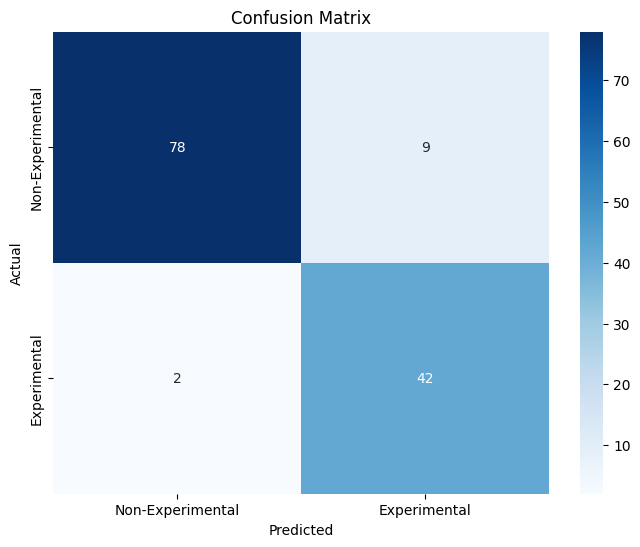

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'YES'/'NO' to True/False in 1st_token column
merged_df['chunk_based_analysis'] = merged_df['chunk_based_analysis'].map({'YES': True, 'NO': False})

# Calculate metrics
accuracy = accuracy_score(merged_df['is_exp_by_human'], merged_df['chunk_based_analysis'])
precision = precision_score(merged_df['is_exp_by_human'], merged_df['chunk_based_analysis'])
recall = recall_score(merged_df['is_exp_by_human'], merged_df['chunk_based_analysis'])
f1 = f1_score(merged_df['is_exp_by_human'], merged_df['chunk_based_analysis'])

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

# Create confusion matrix
cm = confusion_matrix(merged_df['is_exp_by_human'], merged_df['chunk_based_analysis'])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Experimental', 'Experimental'],
            yticklabels=['Non-Experimental', 'Experimental'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
# Find disagreements between model and human labels
disagreements = merged_df[merged_df['chunk_based_analysis'] != merged_df['is_exp_by_human']]

# Display results with relevant columns
print("Rows where model and human disagree:")
print(disagreements[['file_name', 'page_number', 'chunk_based_analysis', 'is_exp_by_human', 'text']].to_string())
print(f"\nTotal disagreements: {len(disagreements)}")

Rows where model and human disagree:
         file_name  page_number  chunk_based_analysis  is_exp_by_human                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Разбивание на чанки особо не помогает улучшить классификацию. Ладно результат можно считать отличным идем дальше. 